In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl

import deepinv as dinv
from deepinv.utils.plotting import plot as dinv_plot
from deepinv.optim.data_fidelity import L2
from deepinv.utils.demo import load_url_image, get_image_url
from tqdm import tqdm, trange  # to visualize progress

from PMCPnP import PMCPnPAnnealing, PMCPnP
from PMCPnP import PMCPnPIterator, PMCPnPAnnealingIterator
from utils import get_blur_physics, get_inpainting_physics
%load_ext autoreload
%autoreload 2

device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

url = get_image_url("butterfly.png")
img_size = 256
x_true = load_url_image(url=url, img_size=img_size).to(device)
x = x_true.clone()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Selected GPU 0 with 15888 MB free memory 


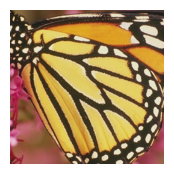

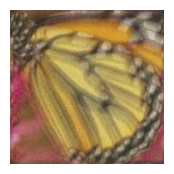

In [14]:
sigma = 0.05  # noise level

physics = get_blur_physics(sigma, device)

#physics = get_inpainting_physics(img_size, sigma, device)

torch.manual_seed(0)

# load Gaussian Likelihood
#x = 2 * x - 1
y = physics(x)
dinv_plot(x_true.detach().cpu())
dinv_plot(y)

In [15]:
x.min(), x.max(), y.min(), y.max()

(tensor(0., device='cuda:0'),
 tensor(0.9882, device='cuda:0'),
 tensor(-0.0562, device='cuda:0'),
 tensor(1.0521, device='cuda:0'))

In [16]:
gamma = 0.0005
alpha = 1
iterations = int(2e3) if torch.cuda.is_available() else 10
sigma_denoiser = sigma
print(np.sqrt(2 * gamma))
print(sigma_denoiser)

likelihood = dinv.optim.L2(sigma=sigma_denoiser)

prior = dinv.optim.ScorePrior(
    #denoiser=dinv.models.DnCNN(pretrained="download")
    #denoiser=dinv.models.DRUNet(pretrained="download")
    denoiser=dinv.models.DiffUNet(large_model=False)
).to(device)


pmc_pnp = PMCPnP(prior=prior,
                 data_fidelity=likelihood,
                 max_iter=iterations,
                 gamma=gamma,
                 sigma=sigma_denoiser,
                 alpha=alpha,)




0.03162277660168379
0.05
new version


In [106]:

pula_mean, pula_var = pmc_pnp(y, physics)

# compute linear inverse
x_lin = physics.A_adjoint(y)

# compute PSNR
print(f"Linear reconstruction PSNR: {dinv.utils.metric.cal_psnr(x, x_lin):.2f} dB")
print(
    f"PreconULA posterior mean PSNR: {dinv.utils.metric.cal_psnr(x, pula_mean):.2f} dB"
)

example_sample = pula_mean + torch.randn(1, device=device) * torch.sqrt(pula_var)


  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [02:15<00:00, 14.73it/s]

Monte Carlo sampling finished! elapsed time=135.86 seconds
Iteration 1999, current converge crit. = 1.21E-04, objective = 1.00E-03 
Linear reconstruction PSNR: 14.78 dB
PreconULA posterior mean PSNR: 26.20 dB


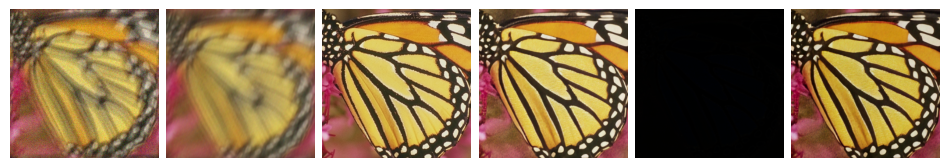

In [107]:
# plot results
imgs = [y, x_lin, x, pula_mean, pula_var, example_sample]
dinv_plot(imgs, rescale_mode='clip')

# Annealing version

In [25]:
iterations = int(2e3) if torch.cuda.is_available() else 10
gamma = 0.0005

xsi = 0.997

base_sigma = sigma * 2
min_sigma = sigma / 10
print(base_sigma, min_sigma)
base_alpha = 1 / (min_sigma**2)
min_alpha = 1
sigmas = torch.Tensor([max(base_sigma * (xsi**i) , min_sigma) for i in range(iterations)])
alphas = torch.Tensor([max(base_alpha * (elem**2), min_alpha) for elem in sigmas]) / 255

print(sigmas[0], sigmas[-1])

pmc_pnp = PMCPnPAnnealing(prior=prior,
                 data_fidelity=likelihood,
                 max_iter=iterations,
                 gamma=gamma,
                 sigmas=sigmas,
                 alphas=alphas,)




0.1 0.005
tensor(0.1000) tensor(0.0050)


In [26]:

pula_mean, pula_var = pmc_pnp(y, physics)

# compute linear inverse
x_lin = physics.A_adjoint(y)

# compute PSNR
print(f"Linear reconstruction PSNR: {dinv.utils.metric.cal_psnr(x, x_lin):.2f} dB")
print(
    f"PreconULA posterior mean PSNR: {dinv.utils.metric.cal_psnr(x, pula_mean):.2f} dB"
)


100%|██████████| 2000/2000 [02:16<00:00, 14.67it/s]


Monte Carlo sampling finished! elapsed time=136.38 seconds
Iteration 1999, current converge crit. = 3.50E-04, objective = 1.00E-03 
Linear reconstruction PSNR: 14.78 dB
PreconULA posterior mean PSNR: 15.82 dB


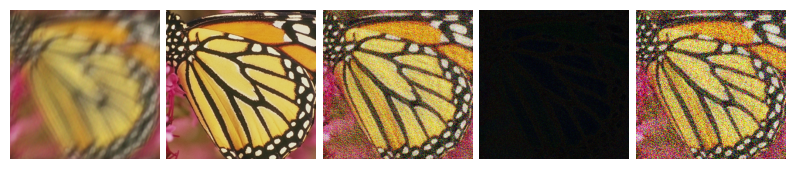

In [121]:
# plot results
example_sample = pula_mean + torch.randn_like(pula_mean) * torch.sqrt(pula_var)

imgs = [x_lin, x, pula_mean, pula_var, example_sample]
dinv_plot(imgs, rescale_mode='clip')

# test with custom MCMC

In [5]:
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

true_sigma = sigma
sigma_denoiser = np.sqrt(2 * gamma) * 2
print("sigma denoiser", sigma_denoiser)
nb_iterations = 2000
gamma_param = 2e-4
alpha_param = 1

denoiser = dinv.models.DRUNet(pretrained="download").to(device)
likelihood = L2(sigma=sigma_denoiser)
physics = get_blur_physics(true_sigma, device)


Selected GPU 0 with 22404 MB free memory 
sigma denoiser 0.0938083151964686


In [7]:

x_0 =  2 * y - 1#torch.randn_like(y, device=device)
print(x_0.norm())


for it in trange(nb_iterations) :
    grad_g = physics.A_adjoint(y - physics.A(x_0)) / (sigma_denoiser**2)
    p = grad_g + (2 * denoiser((x_0 - gamma * grad_g)/2 + 0.5, sigma_denoiser) - 1 - x_0 - gamma * grad_g) / (sigma_denoiser**2)
    x_0 = x_0 - gamma_param * p + torch.randn_like(x_0, device=device) * np.sqrt(2 * gamma_param)
    x_0 = torch.clamp(x_0, -1, 1)
    # print(grad_g.norm(), p.norm(), x_0.norm())
    #x_0 = torch.clamp(x_0, 0, 1)
    if it == 1000 :
        break



tensor(655.5872, device='cuda:0')


  0%|          | 0/2000 [00:00<?, ?it/s]

 50%|█████     | 1000/2000 [00:36<00:36, 27.66it/s]


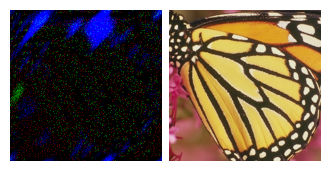

In [8]:
dinv_plot([x_0, x_true])

# test

In [ ]:
denoiser = dinv.models.DRUNet(pretrained="download")
# denoiser = dinv.models.DiffUNet(pretrained='download', large_model=False)
#denoiser = dinv.models.DnCNN(pretrained="download_lipschitz")

32.211029052734375


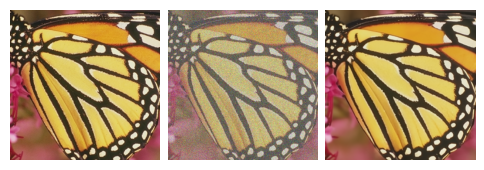

In [ ]:
noise = dinv.physics.GaussianNoise(sigma=0.1)

y = noise(x)

out = denoiser.forward(y.cpu(), 0.1)
print(dinv.utils.metric.cal_psnr(out, x.cpu()))

dinv_plot([x, y, out])

In [ ]:
denoiser(y.cpu(), 0.1)

tensor([[[[0.1751, 0.2339, 0.3546,  ..., 0.2773, 0.2721, 0.2586],
          [0.1490, 0.1764, 0.2441,  ..., 0.2868, 0.2889, 0.2863],
          [0.3340, 0.2188, 0.1784,  ..., 0.2792, 0.2777, 0.2773],
          ...,
          [0.3598, 0.3459, 0.3588,  ..., 0.6075, 0.6015, 0.5957],
          [0.3519, 0.3478, 0.3841,  ..., 0.6082, 0.6039, 0.6003],
          [0.3478, 0.3563, 0.4021,  ..., 0.6102, 0.6087, 0.6073]],

         [[0.1300, 0.1748, 0.2832,  ..., 0.2027, 0.1972, 0.1862],
          [0.1102, 0.1299, 0.1889,  ..., 0.2136, 0.2168, 0.2135],
          [0.3027, 0.1870, 0.1415,  ..., 0.2139, 0.2143, 0.2126],
          ...,
          [0.1174, 0.1075, 0.1085,  ..., 0.3956, 0.3929, 0.3899],
          [0.1101, 0.1084, 0.1214,  ..., 0.3951, 0.3934, 0.3907],
          [0.1158, 0.1126, 0.1347,  ..., 0.3946, 0.3946, 0.3925]],

         [[0.0652, 0.0972, 0.1783,  ..., 0.1830, 0.1768, 0.1702],
          [0.0449, 0.0588, 0.1014,  ..., 0.1931, 0.1941, 0.1912],
          [0.2460, 0.1267, 0.0748,  ..., 0